In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt
import os.path
import matplotlib as mpl
from typing import *


MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000*1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

log = lambda runid, buildstring: f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}/{buildstring}'

# Pause time curve

In [22]:
MIN_PAUSE_USEC = 1
MAX_PAUSE_USEC = 1000*1000 # 1 sec
PAUSE_SIGNIFICANT_DIGITS = 5

def load_phase_time_data(invocation, folder):
    path = "{}.{}/pauses.csv".format(folder, invocation)
    if not os.path.isfile(path):
        return None
    names = ['total', 'wait', 'init', 'prepare', 'closure', 'refclosure', 'refforwarding', 'release', 'final']
    df = pandas.read_csv(path, names=names)
    for name in names:
        df[name] = df[name] / 1000
    return df

def plot_phase_data(bench, title, phase, data: Dict[str, Union[str, List[str]]], invocations = 10, save = None):
    # print('Loading...')
    folders_dict = data
    gcs = list(folders_dict.keys())
    histograms = {}
    for gc in gcs:
        histograms[gc] = []
        for i in range(invocations):
            folders = folders_dict[gc] if isinstance(folders_dict[gc], list) else [folders_dict[gc]]
            for folder in folders:
                histogram = HdrHistogram(MIN_PAUSE_USEC, MAX_PAUSE_USEC, PAUSE_SIGNIFICANT_DIGITS)
                data = load_phase_time_data(i, folder)
                if data is None:
                    continue
                latencies = data[phase]
                for l in latencies:
                    histogram.record_value(l)
                histograms[gc].append(histogram)
    
    # print('Processing...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                x = i.percentile_level_iterated_to
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_df = pandas.DataFrame(percentile_list)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])

    # print('Plotting...')
    fig, ax = plt.subplots(1,1,figsize=(16,12))
    fig.suptitle(title, fontsize=26)
    sns.color_palette()
    colors = ['green', 'blue', 'orange', 'red'][:len(gcs)]
    # print(f'{gcs} {colors}')
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC", palette=colors)
    # sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    ax.set_xscale('log')
    ax.set_xlabel('Percentile', fontsize=26, labelpad=12)
    ax.set_ylabel('Time (msec)', fontsize=26, labelpad=12)
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999', '99.9999'], fontsize=20)
    plt.yticks(fontsize=20)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x / 1000:.3f}'.format(x)))
    plt.legend(fontsize=26)

    if save is not None:
        plt.savefig(save, bbox_inches='tight')

## Phase time

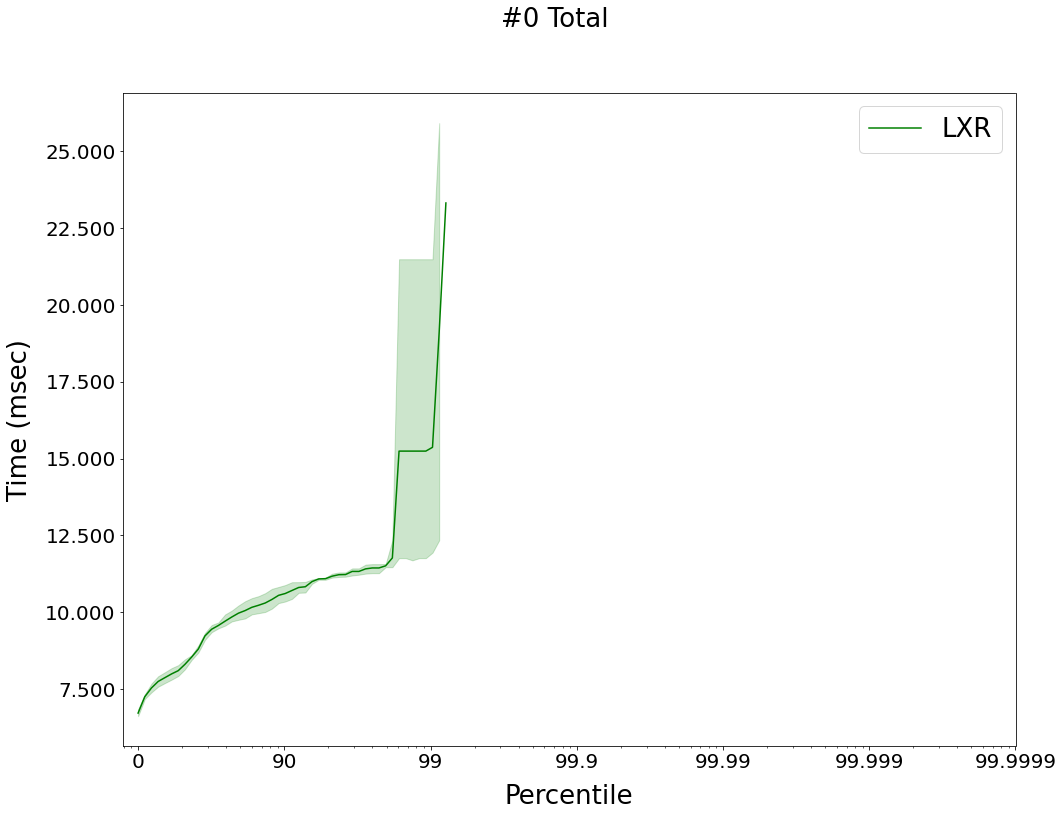

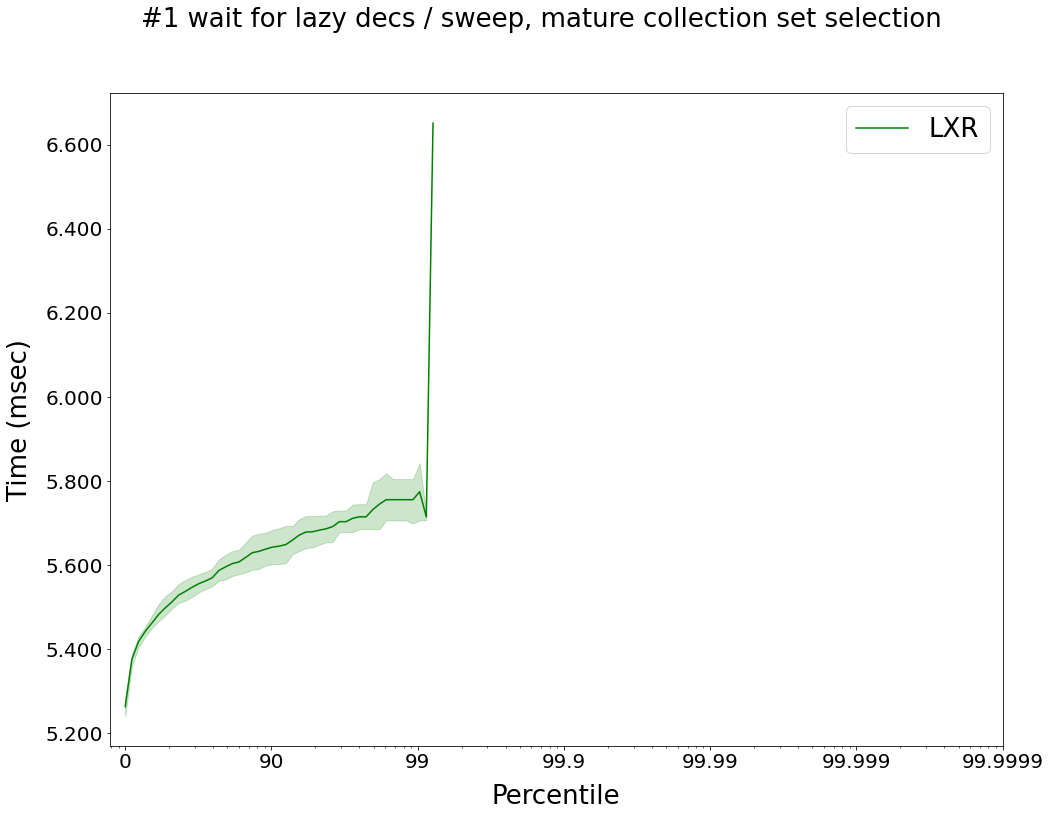

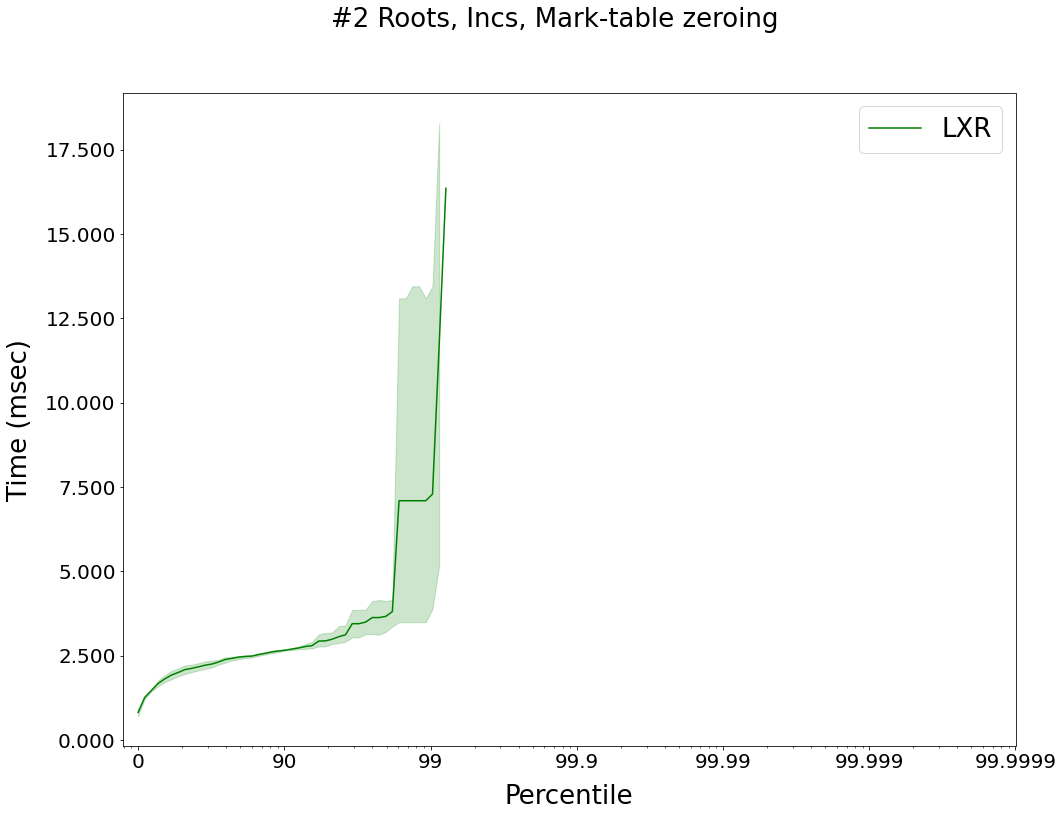

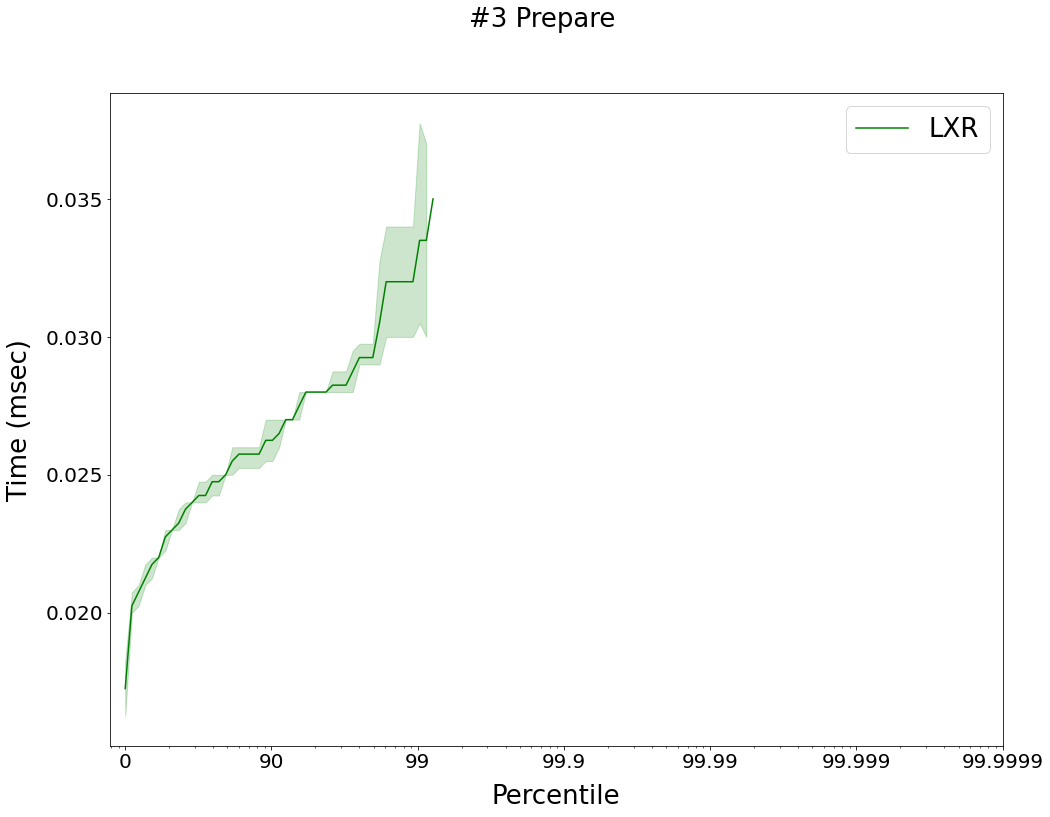

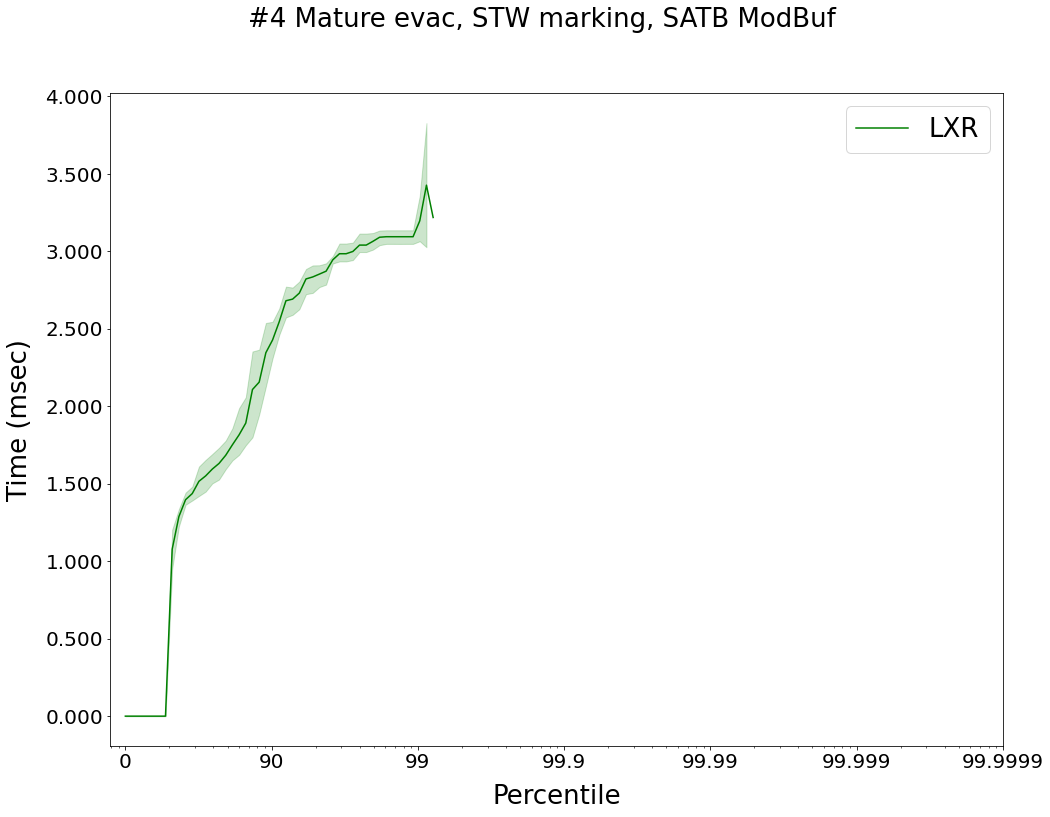

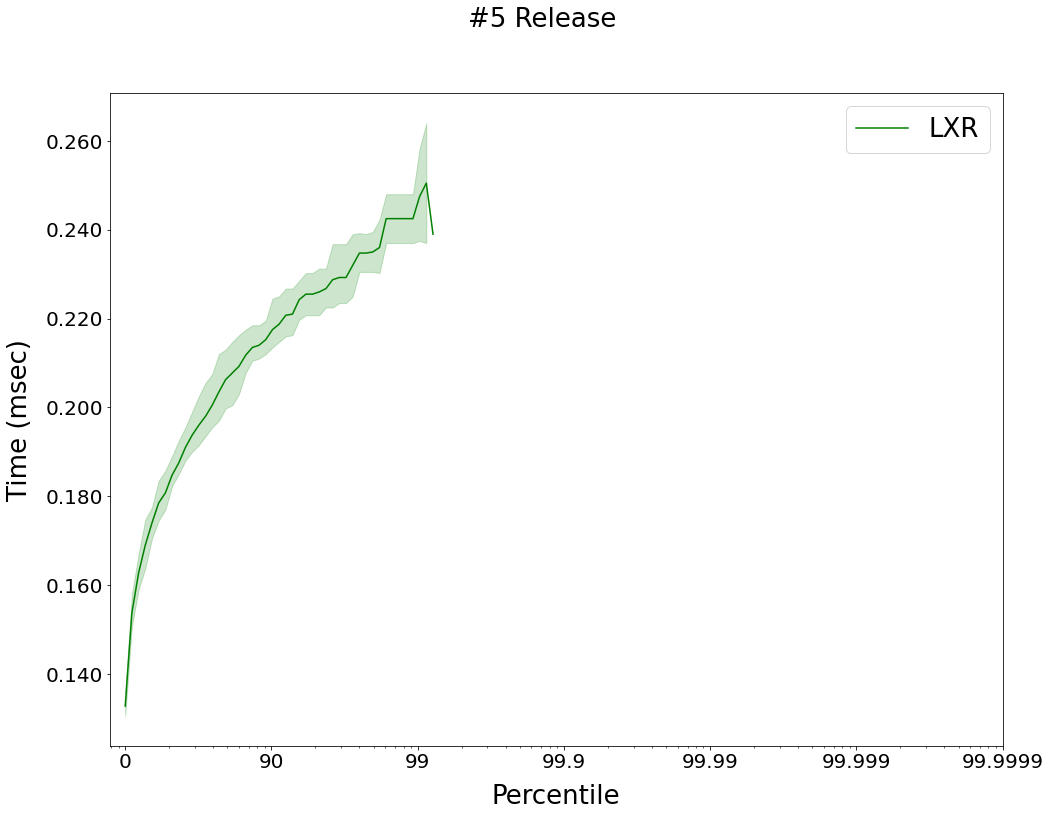

In [24]:
BENCH = 'cassandra'

runid1 = 'elk-2021-12-05-Sun-154101'

def _plot_phase(phase, title):
    plot_phase_data(
        bench = BENCH,
        phase = phase,
        title = title,
        data = {
            'LXR':   log(runid1, 'cassandra.3023.269.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'),
        },
        invocations = 20,
    )
_plot_phase('total', '#0 Total')
_plot_phase('wait', '#1 wait for lazy decs / sweep, mature collection set selection')
_plot_phase('init', '#2 Roots, Incs, Mark-table zeroing')
_plot_phase('prepare', '#3 Prepare')
_plot_phase('closure', '#4 Mature evac, STW marking, SATB ModBuf')
_plot_phase('release', '#5 Release')

## Pauses: h2

Loading...
Processing...
Plotting...
['LXR', 'G1', 'Shen.', 'ZGC'] ['green', 'blue', 'orange', 'red']


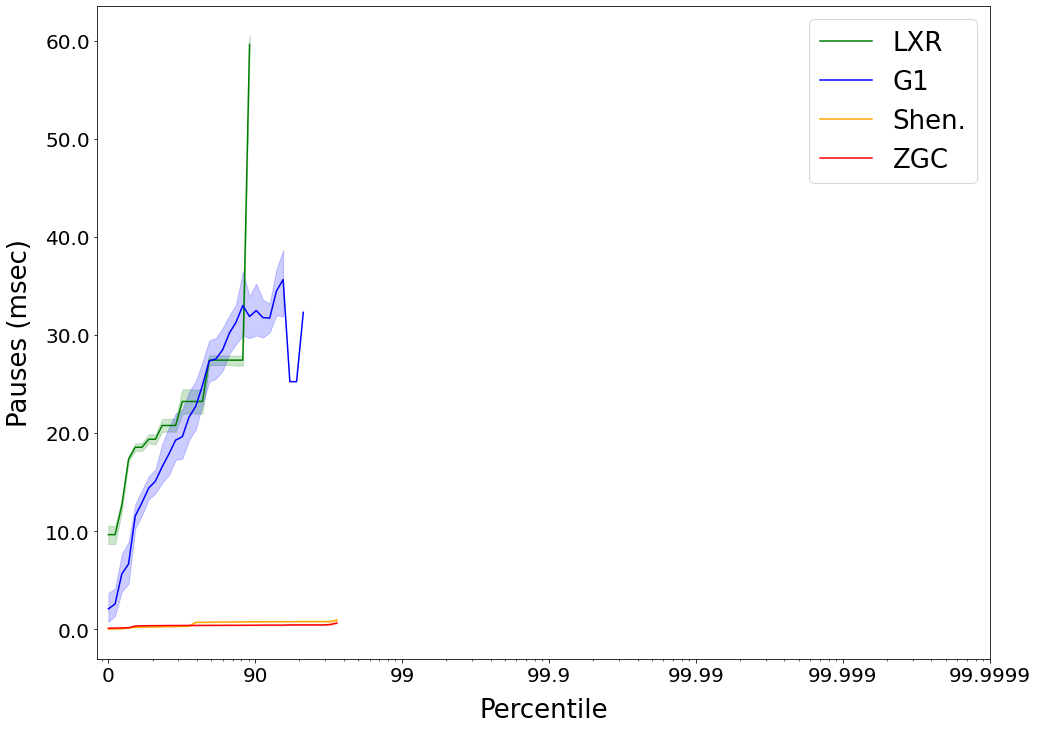

In [5]:
runid1 = 'elk-2021-12-05-Sun-154101'
plot_pause_data(
    bench = 'h2',
    data = {
        'LXR':   log(runid1, 'h2.3023.3489.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'),
        'G1':    log(runid1, 'h2.3023.3489.jdk.g1.common.hs_perf.dacapochopin-29a657f'),
        'Shen.': log(runid1, 'h2.3023.3489.jdk.shenandoah.common.hs_perf.dacapochopin-29a657f'),
        'ZGC':   log(runid1, 'h2.3023.3489.jdk.z.common.hs_perf.dacapochopin-29a657f'),
    },
    invocations = 20,
)

## Pauses: tomcat

Loading...
Processing...
Plotting...
['LXR', 'G1', 'Shen.'] ['green', 'blue', 'orange']


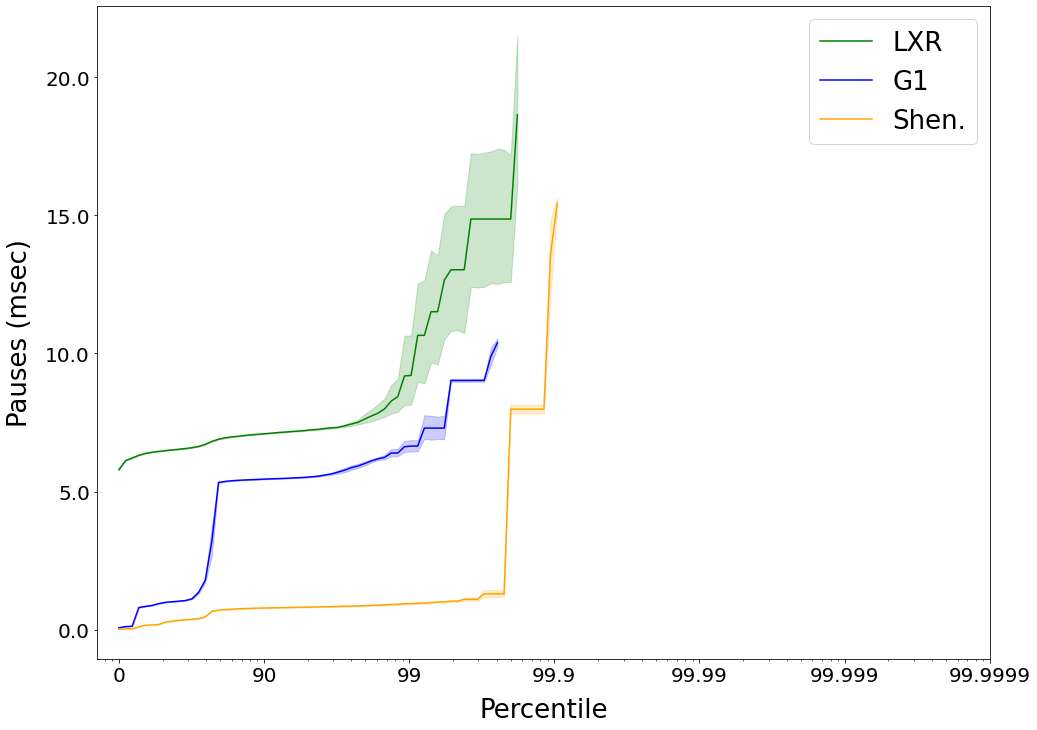

In [6]:
runid1 = 'elk-2021-12-05-Sun-154101'
plot_pause_data(
    bench = 'tomcat',
    data = {
        'LXR':   log(runid1, 'tomcat.3023.76.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'),
        'G1':    log(runid1, 'tomcat.3023.76.jdk.g1.common.hs_perf.dacapochopin-29a657f'),
        'Shen.': log(runid1, 'tomcat.3023.76.jdk.shenandoah.common.hs_perf.dacapochopin-29a657f'),
    },
    invocations = 20,
)